# Baseline 算法

动物分类教程

使用 Python 进行编程文档请参阅 https://docs.python.org/zh-cn/3/contents.html 。

使用 PyTorch 框架，下载、文档等详情参阅 https://pytorch.org/ ，具体中文文档参阅 https://www.pytorch.wiki/ 。

## 环境配置

在运行本代码前，你需要在以下选项二选一完成：本地环境配置或使用 Google Colab * <a href="https://colab.research.google.com/drive/1Lf0Y5-3gvjKKggQTf1zWrEqHYYIVp3z2#scrollTo=Omm0IoVSJ4Kw" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
完成。若你使用 Colab 可以忽略以下配置环境的过程，可直接阅读下一节。

建议你下载 Anaconda 完成虚拟环境的配置，https://www.anaconda.com ，因为在不同的项目中需要的 Python 版本、不同包的版本可能不同，因此需要不同包的管理软件。Anaconda 的使用，参阅 https://anaconda.cloud/support-center ，或 https://zhuanlan.zhihu.com/p/348120084 获得对新手更为友好的中文教程。

Colab 使用建议：你可以使用你的 Google Drive，将数据集上传至 Google Drive 后，进行挂载使用。否则需要每次会话时重复上传。Google Drive 挂载在 Colab 使用参阅 https://blog.csdn.net/aiynmimi/article/details/88238246

## 数据读入

如何读入数据？参阅 https://pytorch.org/tutorials/beginner/basics/data_tutorial.html ，我们进行对数据集的读入。
在真正读入前，我们先进行一些预处理。

In [1]:
NUM_CLASSES = 22
LABELS = [
    "ape", "bear", "bison", "cat", 
    "chicken", "cow", "deer", "dog",
    "dolphin", "duck", "eagle", "fish", 
    "horse", "lion", "lobster", "pig", 
    "rabbit", "shark", "snake", "spider", 
    "turkey", "wolf"
]
LABEL_MAP = {
    0: "ape", 1: "bear", 2: "bison", 3: "cat", 
    4: "chicken", 5: "cow", 6: "deer", 7: "dog",
    8: "dolphin", 9: "duck", 10: "eagle", 11: "fish", 
    12: "horse", 13: "lion", 14: "lobster", 
    15: "pig", 16: "rabbit", 17: "shark", 18: "snake", 
    19: "spider", 20:  "turkey", 21: "wolf"
}

你还需要把训练集进行分割，分割出 Valid 集

由于本任务数据的特殊性，可以直接使用 ImageFolder ，而不需要单独设计 Dataset 类，因此先定义 transformss, 参阅 https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html 。

In [2]:
from torchvision import transforms
import torch
train_transform = transforms.Compose(
    (
        transforms.RandomResizedCrop(176, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomHorizontalFlip(),
        transforms.autoaugment.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        transforms.RandomErasing(p=0.1),
        ))

test_transform = transforms.Compose((transforms.ToTensor(), transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR), transforms.CenterCrop(224), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])))


自定义VisionDataset子类

In [3]:
from torchvision.datasets import VisionDataset
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
from pathlib import Path
import re
class AnimalDataset(VisionDataset):
    def __init__(self, root: str, transforms: Optional[Callable] = None, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None) -> None:
        super().__init__(root, transforms, transform, target_transform)
        data_path = Path(self.root)
        image_list = list(data_path.glob('*.png'))
        self.images = [str(i) for i in image_list]
    
    def __getitem__(self, index: int) -> Any:
        image_path = self.images[index]
        image = Image.open(image_path).convert('RGB')  # 读取到的是RGB， W, H, C
        image = self.transforms(image)   # transform转化image为：C, H, W

        label = re.sub(r'\D', "", image_path)
        return image, int(label)
    
    def __len__(self) -> int:
        return len(self.images)
    

将训练、测试集读入 DataLoader

In [4]:
import os

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

data_path = './Animals Dataset' #@param 
batch_size = 32 #@param
num_workers = 0 #@param

train_path = (os.path.join(data_path, 'train'))
test_path = (os.path.join(data_path, 'test'))
val_path = (os.path.join(data_path, 'val'))

train_dataset = ImageFolder(
    train_path,
    train_transform)
val_dataset = ImageFolder(
    val_path,
    test_transform)
test_dataset = AnimalDataset(
    test_path,
    test_transform)


随机挑选16张图片测试数据读入是否顺利

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

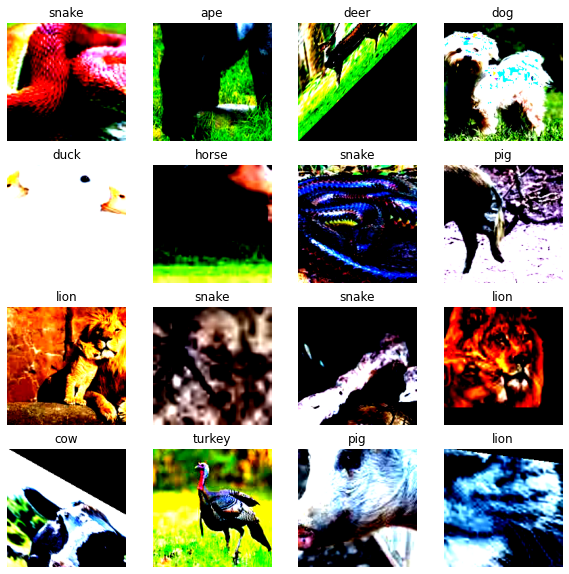

In [5]:
import matplotlib.pyplot as plt
from torch import randint
%matplotlib inline
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(LABEL_MAP[label])
    plt.axis("off")
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img.squeeze())
plt.show()

## 建立模型

本节介绍如何定义一个模型，参阅 https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html 

先进行预处理

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    num_workers=num_workers,
    shuffle=True)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=num_workers)

Using cuda device


定义模型类，注意到 PyTorch 是动态图，因此在数据进行前向传播时我们相当于已经定义了 Backpropagation 反向传播。

这样模型就可以定义为：

In [7]:
from torchvision import models
model = models.resnet50().to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

设置模型训练超参数、损失函数与优化器

In [8]:
learning_rate = 1e-2  # @param
# batch_size = 32 #@param 此处貌似在DataLoader部分定义了
epochs = 600  # @param
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=2e-5, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, verbose=True)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)
warmup_lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.001, total_iters=5)
main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs-5)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer, schedulers=[warmup_lr_scheduler, main_scheduler], milestones=[5])


定义评价指标

In [9]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self, name, fmt=':f'):
      self.name = name
      self.fmt = fmt
      self.reset()

  def reset(self):
      self.val = 0
      self.avg = 0
      self.sum = 0
      self.count = 0

  def update(self, val, n=1):
      self.val = val
      self.sum += val * n
      self.count += n
      self.avg = self.sum / self.count

  def __str__(self):
      fmtstr = '{name} {avg' + self.fmt + '}'
      return fmtstr.format(**self.__dict__)

def accuracy(output, target, topk=(1,)):
  """Computes the accuracy over the k top predictions for the specified values of k"""
  with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

batch_time = AverageMeter('Time', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
losses = AverageMeter('Training loss', ':.4e')
top1 = AverageMeter('Acc@1', ':6.2f')
top5 = AverageMeter('Acc@5', ':6.2f')

训练

In [10]:
import time

val_loss_history = []
loss_history = []
top1_history = []
top5_history = []
best_loss = 0x7fffffff

start = time.time()
for i in range(epochs):
  for batch, (X, y) in enumerate(train_loader):
    X = X.to(device)
    y = y.to(device)
    data_time.update(time.time() - start)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  batch_time.update(time.time() - start)
  start = time.time()

  with torch.no_grad():
    for batch, (X, y) in enumerate(val_loader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      val_loss = loss_fn(pred, y)
      if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        best_epoch = i
        best_model = model
      acc1, acc5 = accuracy(pred, y, topk=(1, 5))
      loss_history.append(loss.item())
      val_loss_history.append(val_loss.item())
      top1_history.append(acc1[0])
      top5_history.append(acc5[0])
      losses.update(loss.item(), X.size(0))
      top1.update(acc1[0], X.size(0))
      top5.update(acc5[0], X.size(0))
    scheduler.step()
      
  print(f"Epoch:{i + 1}: {batch_time}, {losses}, Validation loss {val_loss.item():.4e}, {top1}, {top5}, learning rate {optimizer.state_dict()['param_groups'][0]['lr']}")
  losses.reset()
  top1.reset()
  top5.reset()

print(f"Best Epoch:{best_epoch + 1}, loss: {best_loss}, Acc@1: {top1_history[best_epoch]}, Acc@5: {top5_history[best_epoch]}")


Epoch:1: Time 16.161, Training loss 6.7298e+00, Validation loss 6.7955e+00, Acc@1   1.03, Acc@5   4.11, learning rate 0.002008
Epoch:2: Time 14.352, Training loss 3.3988e+00, Validation loss 3.3503e+00, Acc@1   6.51, Acc@5  29.79, learning rate 0.004006
Epoch:3: Time 13.700, Training loss 3.7702e+00, Validation loss 3.4346e+00, Acc@1   6.51, Acc@5  32.53, learning rate 0.006004
Epoch:4: Time 13.381, Training loss 3.9800e+00, Validation loss 3.6201e+00, Acc@1   6.16, Acc@5  26.37, learning rate 0.008002


/home/nightingalecen/miniconda3/envs/LearningDeep/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch:5: Time 13.194, Training loss 3.4031e+00, Validation loss 3.3682e+00, Acc@1  10.27, Acc@5  36.99, learning rate 0.01
Epoch:6: Time 13.111, Training loss 2.9539e+00, Validation loss 2.9341e+00, Acc@1  12.67, Acc@5  49.32, learning rate 0.009999930304487875
Epoch:7: Time 13.016, Training loss 2.8254e+00, Validation loss 2.9029e+00, Acc@1  14.73, Acc@5  47.26, learning rate 0.009999721219894482
Epoch:8: Time 13.000, Training loss 2.8266e+00, Validation loss 2.8160e+00, Acc@1  17.47, Acc@5  46.58, learning rate 0.009999372752048728
Epoch:9: Time 13.103, Training loss 3.2857e+00, Validation loss 2.7857e+00, Acc@1  17.12, Acc@5  50.00, learning rate 0.009998884910665268
Epoch:10: Time 13.164, Training loss 3.1275e+00, Validation loss 2.7145e+00, Acc@1  18.84, Acc@5  51.03, learning rate 0.009998257709344247
Epoch:11: Time 13.126, Training loss 2.8561e+00, Validation loss 2.7008e+00, Acc@1  21.23, Acc@5  54.79, learning rate 0.009997491165570907
Epoch:12: Time 13.095, Training loss 2.47

Epoch:64: Time 12.936, Training loss 1.8295e+00, Validation loss 1.8568e+00, Acc@1  44.52, Acc@5  80.82, learning rate 0.009759345020403229
Epoch:65: Time 12.933, Training loss 2.0638e+00, Validation loss 1.7777e+00, Acc@1  47.60, Acc@5  82.88, learning rate 0.009751187000305072
Epoch:66: Time 12.929, Training loss 2.2757e+00, Validation loss 1.9316e+00, Acc@1  42.81, Acc@5  80.48, learning rate 0.009742896525642438
Epoch:67: Time 12.925, Training loss 1.8656e+00, Validation loss 1.8235e+00, Acc@1  47.95, Acc@5  77.40, learning rate 0.009734473827538878
Epoch:68: Time 12.922, Training loss 2.2328e+00, Validation loss 1.7987e+00, Acc@1  50.34, Acc@5  81.51, learning rate 0.009725919140804095
Epoch:69: Time 12.920, Training loss 2.0575e+00, Validation loss 1.8526e+00, Acc@1  46.92, Acc@5  82.88, learning rate 0.009717232703927398
Epoch:70: Time 12.916, Training loss 2.2511e+00, Validation loss 1.8647e+00, Acc@1  45.21, Acc@5  84.25, learning rate 0.009708414759071055
Epoch:71: Time 12.91

Epoch:123: Time 12.850, Training loss 2.0692e+00, Validation loss 1.5222e+00, Acc@1  52.05, Acc@5  86.30, learning rate 0.009060546009294814
Epoch:124: Time 12.848, Training loss 1.6940e+00, Validation loss 1.4587e+00, Acc@1  57.53, Acc@5  88.01, learning rate 0.009045084971874734
Epoch:125: Time 12.846, Training loss 9.4491e-01, Validation loss 1.4379e+00, Acc@1  54.45, Acc@5  86.64, learning rate 0.009029511164747171
Epoch:126: Time 12.845, Training loss 1.5717e+00, Validation loss 1.4676e+00, Acc@1  56.85, Acc@5  87.67, learning rate 0.00901382502208191
Epoch:127: Time 12.843, Training loss 1.6232e+00, Validation loss 1.4618e+00, Acc@1  55.82, Acc@5  85.96, learning rate 0.00899802698118045
Epoch:128: Time 12.843, Training loss 1.8740e+00, Validation loss 1.4042e+00, Acc@1  57.53, Acc@5  88.70, learning rate 0.008982117482463813
Epoch:129: Time 12.841, Training loss 1.8297e+00, Validation loss 1.4512e+00, Acc@1  54.79, Acc@5  86.64, learning rate 0.008966096969460262
Epoch:130: Time

Epoch:182: Time 12.806, Training loss 1.5902e+00, Validation loss 1.3401e+00, Acc@1  60.27, Acc@5  85.96, learning rate 0.007970870751378967
Epoch:183: Time 12.806, Training loss 1.1930e+00, Validation loss 1.2729e+00, Acc@1  60.27, Acc@5  88.36, learning rate 0.007949595006894914
Epoch:184: Time 12.805, Training loss 1.2949e+00, Validation loss 1.2613e+00, Acc@1  61.99, Acc@5  89.38, learning rate 0.007928237032997035
Epoch:185: Time 12.804, Training loss 1.1428e+00, Validation loss 1.3155e+00, Acc@1  58.22, Acc@5  85.62, learning rate 0.007906797425107298
Epoch:186: Time 12.803, Training loss 9.2605e-01, Validation loss 1.3401e+00, Acc@1  59.25, Acc@5  85.96, learning rate 0.007885276780923486
Epoch:187: Time 12.802, Training loss 7.0803e-01, Validation loss 1.3737e+00, Acc@1  56.16, Acc@5  86.30, learning rate 0.007863675700402525
Epoch:188: Time 12.801, Training loss 1.4754e+00, Validation loss 1.2856e+00, Acc@1  60.27, Acc@5  88.70, learning rate 0.007841994785743763
Epoch:189: Ti

Epoch:241: Time 12.795, Training loss 1.0046e+00, Validation loss 1.2342e+00, Acc@1  65.07, Acc@5  88.36, learning rate 0.006595213557440024
Epoch:242: Time 12.795, Training loss 1.1208e+00, Validation loss 1.1897e+00, Acc@1  63.70, Acc@5  90.75, learning rate 0.006570171151433886
Epoch:243: Time 12.794, Training loss 7.9579e-01, Validation loss 1.1925e+00, Acc@1  65.75, Acc@5  88.01, learning rate 0.0065450849718747366
Epoch:244: Time 12.795, Training loss 7.9592e-01, Validation loss 1.1503e+00, Acc@1  67.81, Acc@5  87.33, learning rate 0.006519955718120232
Epoch:245: Time 12.794, Training loss 7.7743e-01, Validation loss 1.1654e+00, Acc@1  65.07, Acc@5  90.07, learning rate 0.006494784090728853
Epoch:246: Time 12.793, Training loss 9.6503e-01, Validation loss 1.2084e+00, Acc@1  65.07, Acc@5  90.41, learning rate 0.006469570791440384
Epoch:247: Time 12.792, Training loss 1.0046e+00, Validation loss 1.1363e+00, Acc@1  63.01, Acc@5  89.73, learning rate 0.006444316523156349
Epoch:248: T

Epoch:300: Time 12.780, Training loss 7.3716e-01, Validation loss 1.2139e+00, Acc@1  65.07, Acc@5  89.73, learning rate 0.005065997929053797
Epoch:301: Time 12.781, Training loss 2.8100e-01, Validation loss 1.1608e+00, Acc@1  64.38, Acc@5  89.04, learning rate 0.005039599493408155
Epoch:302: Time 12.782, Training loss 4.9255e-01, Validation loss 1.1041e+00, Acc@1  68.15, Acc@5  90.41, learning rate 0.005013199953799724
Epoch:303: Time 12.782, Training loss 1.0903e+00, Validation loss 1.1422e+00, Acc@1  66.78, Acc@5  87.67, learning rate 0.004986800046200279
Epoch:304: Time 12.783, Training loss 7.7260e-01, Validation loss 1.1568e+00, Acc@1  66.44, Acc@5  88.01, learning rate 0.0049604005065918486
Epoch:305: Time 12.784, Training loss 7.4418e-01, Validation loss 1.1072e+00, Acc@1  68.15, Acc@5  89.73, learning rate 0.004934002070946208
Epoch:306: Time 12.784, Training loss 6.1355e-01, Validation loss 1.2103e+00, Acc@1  61.99, Acc@5  89.38, learning rate 0.004907605475204354
Epoch:307: T

Epoch:359: Time 12.779, Training loss 6.8363e-01, Validation loss 1.0891e+00, Acc@1  65.75, Acc@5  90.07, learning rate 0.0035304292085596174
Epoch:360: Time 12.779, Training loss 6.7806e-01, Validation loss 1.0402e+00, Acc@1  67.12, Acc@5  89.73, learning rate 0.003505215909271151
Epoch:361: Time 12.779, Training loss 5.9146e-01, Validation loss 1.0734e+00, Acc@1  69.52, Acc@5  90.75, learning rate 0.003480044281879771
Epoch:362: Time 12.779, Training loss 2.9254e-01, Validation loss 1.1031e+00, Acc@1  66.78, Acc@5  89.38, learning rate 0.003454915028125266
Epoch:363: Time 12.779, Training loss 5.3796e-01, Validation loss 1.0850e+00, Acc@1  67.47, Acc@5  91.78, learning rate 0.003429828848566116
Epoch:364: Time 12.778, Training loss 9.1604e-01, Validation loss 1.0563e+00, Acc@1  68.15, Acc@5  90.75, learning rate 0.003404786442559978
Epoch:365: Time 12.778, Training loss 3.1423e-01, Validation loss 1.1089e+00, Acc@1  66.78, Acc@5  92.12, learning rate 0.0033797885082441728
Epoch:366: 

Epoch:417: Time 12.770, Training loss 3.6869e-01, Validation loss 1.1367e+00, Acc@1  65.75, Acc@5  90.75, learning rate 0.0021580052142562375
Epoch:418: Time 12.770, Training loss 3.9613e-01, Validation loss 1.1423e+00, Acc@1  64.38, Acc@5  90.07, learning rate 0.002136324299597474
Epoch:419: Time 12.770, Training loss 6.5475e-01, Validation loss 1.1269e+00, Acc@1  65.41, Acc@5  90.07, learning rate 0.0021147232190765137
Epoch:420: Time 12.769, Training loss 7.6445e-01, Validation loss 1.0961e+00, Acc@1  70.21, Acc@5  89.73, learning rate 0.0020932025748927013
Epoch:421: Time 12.769, Training loss 5.8945e-01, Validation loss 1.1490e+00, Acc@1  67.47, Acc@5  90.07, learning rate 0.002071762967002963
Epoch:422: Time 12.770, Training loss 5.9450e-01, Validation loss 1.1002e+00, Acc@1  69.86, Acc@5  91.78, learning rate 0.0020504049931050834
Epoch:423: Time 12.771, Training loss 4.6555e-01, Validation loss 1.0454e+00, Acc@1  69.86, Acc@5  90.75, learning rate 0.002029129248621031
Epoch:424

Epoch:475: Time 12.770, Training loss 4.7211e-01, Validation loss 1.1326e+00, Acc@1  64.38, Acc@5  91.10, learning rate 0.0010500341112070599
Epoch:476: Time 12.770, Training loss 7.2898e-01, Validation loss 1.1117e+00, Acc@1  66.10, Acc@5  90.75, learning rate 0.0010339030305397368
Epoch:477: Time 12.769, Training loss 4.3890e-01, Validation loss 1.1188e+00, Acc@1  66.10, Acc@5  90.07, learning rate 0.001017882517536184
Epoch:478: Time 12.769, Training loss 5.3141e-01, Validation loss 1.1554e+00, Acc@1  65.41, Acc@5  90.41, learning rate 0.0010019730188195449
Epoch:479: Time 12.769, Training loss 1.0781e+00, Validation loss 1.1553e+00, Acc@1  66.10, Acc@5  90.41, learning rate 0.0009861749779180868
Epoch:480: Time 12.769, Training loss 3.5632e-01, Validation loss 1.1466e+00, Acc@1  67.12, Acc@5  91.10, learning rate 0.0009704888352528252
Epoch:481: Time 12.769, Training loss 4.5281e-01, Validation loss 1.1224e+00, Acc@1  66.78, Acc@5  91.44, learning rate 0.0009549150281252627
Epoch:4

Epoch:533: Time 12.764, Training loss 3.8664e-01, Validation loss 1.1333e+00, Acc@1  68.15, Acc@5  90.41, learning rate 0.00030961466760732505
Epoch:534: Time 12.764, Training loss 8.3210e-02, Validation loss 1.1418e+00, Acc@1  68.15, Acc@5  90.41, learning rate 0.00030053444793646004
Epoch:535: Time 12.764, Training loss 9.5524e-01, Validation loss 1.1311e+00, Acc@1  67.81, Acc@5  90.07, learning rate 0.0002915852409289419
Epoch:536: Time 12.764, Training loss 4.0505e-01, Validation loss 1.1342e+00, Acc@1  68.15, Acc@5  90.41, learning rate 0.00028276729607259945
Epoch:537: Time 12.764, Training loss 2.2410e-01, Validation loss 1.1579e+00, Acc@1  68.84, Acc@5  90.41, learning rate 0.00027408085919590247
Epoch:538: Time 12.764, Training loss 5.4722e-01, Validation loss 1.1454e+00, Acc@1  68.49, Acc@5  90.41, learning rate 0.0002655261724611195
Epoch:539: Time 12.765, Training loss 5.5959e-01, Validation loss 1.1456e+00, Acc@1  68.84, Acc@5  90.41, learning rate 0.00025710347435755937
E

Epoch:591: Time 12.770, Training loss 1.7278e-01, Validation loss 1.1275e+00, Acc@1  68.15, Acc@5  91.10, learning rate 5.644287344960251e-06
Epoch:592: Time 12.770, Training loss 9.7948e-01, Validation loss 1.1276e+00, Acc@1  68.15, Acc@5  91.10, learning rate 4.459859969241918e-06
Epoch:593: Time 12.770, Training loss 4.6755e-01, Validation loss 1.1276e+00, Acc@1  68.15, Acc@5  91.10, learning rate 3.4146992848854684e-06
Epoch:594: Time 12.769, Training loss 3.5588e-01, Validation loss 1.1276e+00, Acc@1  68.15, Acc@5  91.10, learning rate 2.5088344290946634e-06
Epoch:595: Time 12.770, Training loss 4.7507e-01, Validation loss 1.1276e+00, Acc@1  68.15, Acc@5  91.10, learning rate 1.7422906557557068e-06
Epoch:596: Time 12.769, Training loss 7.1448e-01, Validation loss 1.1277e+00, Acc@1  68.15, Acc@5  91.10, learning rate 1.1150893347328103e-06
Epoch:597: Time 12.770, Training loss 6.3182e-01, Validation loss 1.1277e+00, Acc@1  68.15, Acc@5  91.10, learning rate 6.272479512731132e-07
Ep

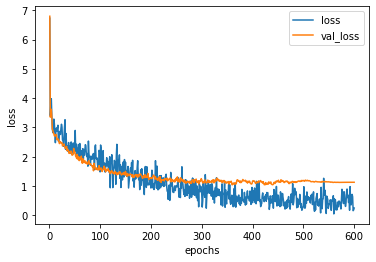

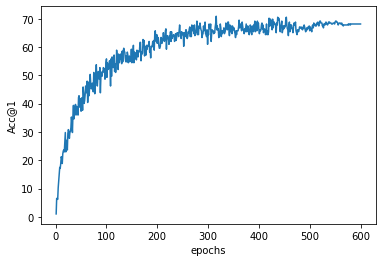

<Figure size 432x288 with 0 Axes>

In [11]:
import numpy as np
plt.plot(np.arange(1, epochs+1), loss_history, label="loss")
plt.plot(np.arange(1, epochs+1), val_loss_history, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
#plt.savefig("loss.png")
plt.show()
plt.clf()
plt.plot(np.arange(1, epochs+1), [i.item() for i in top1_history])
plt.xlabel("epochs")
plt.ylabel("Acc@1")
#plt.savefig("Acc.png")
plt.show()
plt.clf()

由于模型过于简单，因此训练准确率不高。你可以尝试训练其它的模型（甚至于预训练模型，但预训练模型如何进行训练也是一个值得讨论的问题）。
同时，这里并没有使用 Valid 集来进行评价，而是使用了 train 集，你可以尝试加入 Valid 集（如提前分割，或用其他方式等）



# 输出结果

输出结果非常简单，与训练类似，但模型不能更新参数

In [12]:
#model = torch.load('./ResNet34_8.30_1700.pt')

In [13]:
import numpy as np
def test(model, test_image, name_prefix):
  model.eval()
  labels = []
  image_numbers = []
  with torch.no_grad():
    for _, (images, label) in enumerate(test_image):
      images = images.to(device)
      y = model(images)
      batch_labels = torch.argmax(y, dim=1)
      labels.append(batch_labels)
      image_numbers.append(label)
  ans = torch.cat(labels, 0).cpu().numpy()
  image_numbers = torch.cat(image_numbers, 0).cpu().numpy()
  res = {image_numbers[i]:LABEL_MAP[j] for i, j in enumerate(ans)}
  print(f"{name_prefix} model result:", res)
  return res

res = test(best_model, test_loader, "best")



best model result: {0: 'horse', 1: 'duck', 10: 'deer', 100: 'chicken', 101: 'horse', 102: 'pig', 103: 'cat', 104: 'bear', 105: 'lobster', 106: 'pig', 107: 'eagle', 108: 'bison', 109: 'turkey', 11: 'cat', 12: 'ape', 13: 'fish', 14: 'turkey', 15: 'dog', 16: 'chicken', 17: 'bison', 18: 'ape', 2: 'dog', 20: 'duck', 21: 'turkey', 22: 'shark', 23: 'dolphin', 24: 'bear', 25: 'duck', 26: 'cat', 27: 'pig', 28: 'lion', 29: 'chicken', 3: 'dog', 30: 'duck', 31: 'shark', 32: 'chicken', 33: 'cat', 34: 'snake', 35: 'deer', 36: 'lobster', 37: 'ape', 38: 'lion', 4: 'dog', 40: 'cow', 41: 'lobster', 42: 'eagle', 43: 'snake', 44: 'spider', 45: 'eagle', 46: 'rabbit', 47: 'wolf', 48: 'dog', 49: 'lobster', 5: 'fish', 50: 'shark', 51: 'lobster', 52: 'chicken', 53: 'lion', 54: 'dolphin', 55: 'spider', 56: 'deer', 57: 'shark', 58: 'bison', 6: 'chicken', 60: 'snake', 61: 'bison', 62: 'spider', 63: 'duck', 64: 'snake', 65: 'deer', 66: 'lobster', 67: 'ape', 68: 'dolphin', 69: 'deer', 7: 'lion', 70: 'bear', 71: 'ap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

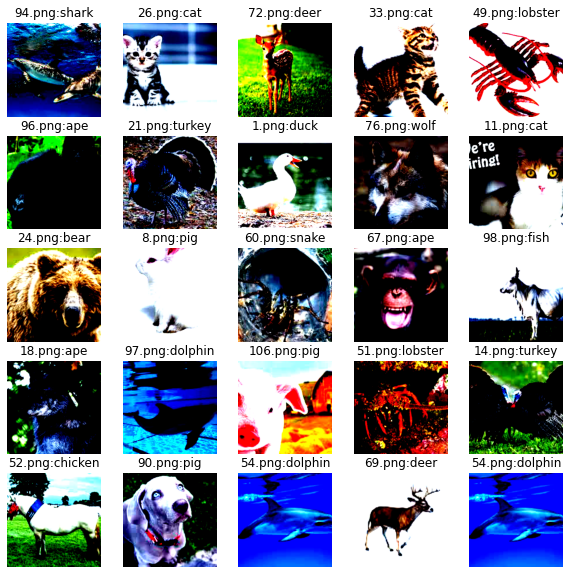

In [18]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = randint(len(test_dataset), size=(1,)).item()
    img, num = test_dataset[sample_idx]
    label = res[num]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{num}.png:{label}")
    plt.axis("off")
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img.squeeze())
plt.show()

# 保存模型

参阅 https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [15]:
#网络_日期_时间.pt
import time
t = time.localtime(time.time())
torch.save(best_model, f'./ResNet50_{t[1]}.{t[2]}_{t[3]}{t[4]}.pt')

In [16]:
#model = torch.load('model.path')